## Lab: Predicting Chronic Kidney Disease in Patients


We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import patsy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:

df = pd.read_csv('./chronic_kidney_disease_full.csv')

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer:

In [ ]:

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [ ]:
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [ ]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [ ]:
df_copy = df.dropna()

In [ ]:

df_copy.shape

(158, 25)

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

*Answer*:158 rows would remain.

One downside of dropping rows with missing data is that we would be losing the data in the columns that do have valid values.

Another downside of dropping rows is that we would no longer be dealing with a 'random' sample of respondents.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

In [ ]:
1.# Any columns/features that involve human measurement may contain human error, i.e. faulty practices.
2. #Some columns deal with data that can be largely temporary, making them largely influenced by timing.
3. #Some records may have been mistakenly adjusted/rounded/recorded incorrectly.

3.0

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer:

In [ ]:
#Build a model that tells everyone that they have CKD; the only error that could occur is a Type I Error, or a False Positive.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

In [ ]:
#We optimized ** Sensitivity ** and the False Negative Rate by minimizing ** False Negatives**.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:

In [ ]:
#One disadvantage to the model described in problem 6 which tells everyone that they have CKD is that the model will produce many False Positives, causing a lot of undue stress and worry.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer:

In [ ]:
#Build a model that tells everyone that they do not have CKD; the only error that could occur is a Type II Error, or a False Negative

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

In [ ]:
#We optimized ** Specificity ** and the False Positive Rate by minimizing ** False Positives**.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer:

In [ ]:
#One disadvantage to the model described in problem 9 which tells everyone that they do not have CKD is that the model will produce many False Negatives, causing a lot of sick people to believe they are not sick and not take any action to help themselves

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [ ]:
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [ ]:
df.drop(['rbc','pc','sod','pot','pcv','wbcc','rbcc'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   pcc     396 non-null    object 
 6   ba      396 non-null    object 
 7   bgr     356 non-null    float64
 8   bu      381 non-null    float64
 9   sc      383 non-null    float64
 10  hemo    348 non-null    float64
 11  htn     398 non-null    object 
 12  dm      398 non-null    object 
 13  cad     398 non-null    object 
 14  appet   399 non-null    object 
 15  pe      399 non-null    object 
 16  ane     399 non-null    object 
 17  class   400 non-null    object 
dtypes: float64(9), object(9)
memory usage: 56.4+ KB


In [ ]:
#Build model:

In [ ]:
df_v1 = df

In [ ]:
df_v1.replace(np.nan, 0, inplace=True)

In [ ]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     400 non-null    float64
 1   bp      400 non-null    float64
 2   sg      400 non-null    float64
 3   al      400 non-null    float64
 4   su      400 non-null    float64
 5   pcc     400 non-null    object 
 6   ba      400 non-null    object 
 7   bgr     400 non-null    float64
 8   bu      400 non-null    float64
 9   sc      400 non-null    float64
 10  hemo    400 non-null    float64
 11  htn     400 non-null    object 
 12  dm      400 non-null    object 
 13  cad     400 non-null    object 
 14  appet   400 non-null    object 
 15  pe      400 non-null    object 
 16  ane     400 non-null    object 
 17  class   400 non-null    object 
dtypes: float64(9), object(9)
memory usage: 56.4+ KB


In [ ]:
df_v1['pcc'].value_counts()

notpresent    354
present        42
0               4
Name: pcc, dtype: int64

In [ ]:
df_v1['pcc'].replace(0, 'present', inplace=True)

In [ ]:
df_v1['pcc'].value_counts()

notpresent    354
present        46
Name: pcc, dtype: int64

In [ ]:

df_v1['ba'].value_counts()

notpresent    374
present        22
0               4
Name: ba, dtype: int64

In [ ]:
df_v1['ba'].replace(0, 'present', inplace=True)

In [ ]:
df_v1['ba'].value_counts()

notpresent    374
present        26
Name: ba, dtype: int64

In [ ]:
df_v1['htn'].value_counts()

no     251
yes    147
0        2
Name: htn, dtype: int64

In [ ]:
df_v1['htn'].replace(0, 'yes', inplace=True)

In [ ]:
df_v1['htn'].value_counts()

no     251
yes    149
Name: htn, dtype: int64

In [ ]:

df_v1['dm'].value_counts()

no     261
yes    137
0        2
Name: dm, dtype: int64

In [ ]:
df_v1['dm'].replace(0, 'yes', inplace=True)

In [ ]:
df_v1['dm'].value_counts()

no     261
yes    139
Name: dm, dtype: int64

In [ ]:
df_v1['cad'].value_counts()

no     364
yes     34
0        2
Name: cad, dtype: int64

In [ ]:
df_v1['cad'].replace(0, 'yes', inplace=True)

In [ ]:

df_v1['cad'].value_counts()

no     364
yes     36
Name: cad, dtype: int64

In [ ]:

df_v1['appet'].value_counts()

good    317
poor     82
0         1
Name: appet, dtype: int64

In [ ]:
df_v1['appet'].replace(0, 'poor', inplace=True)

In [ ]:

df_v1['appet'].value_counts()

good    317
poor     83
Name: appet, dtype: int64

In [ ]:

df_v1['pe'].value_counts()

no     323
yes     76
0        1
Name: pe, dtype: int64

In [ ]:

df_v1['ane'].value_counts()


no     339
yes     60
0        1
Name: ane, dtype: int64

In [ ]:

df_v1['ane'].replace(0, 'yes', inplace=True)

In [ ]:

df_v1['ane'].value_counts()

no     339
yes     61
Name: ane, dtype: int64

In [ ]:

df_v1['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

In [ ]:
df_v1 = pd.get_dummies(data=df_v1, drop_first=True)



In [ ]:
df_v1.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'hemo', 'pcc_present',
       'ba_present', 'htn_yes', 'dm_yes', 'cad_yes', 'appet_poor', 'pe_no',
       'pe_yes', 'ane_yes', 'class_notckd'],
      dtype='object')

In [ ]:
df_v1.drop('class_notckd', axis=1, inplace=True)


In [ ]:
df_v1 ['class'] = df['class']

In [ ]:
df_v1.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'hemo', 'pcc_present',
       'ba_present', 'htn_yes', 'dm_yes', 'cad_yes', 'appet_poor', 'pe_no',
       'pe_yes', 'ane_yes', 'class'],
      dtype='object')

In [ ]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          400 non-null    float64
 1   bp           400 non-null    float64
 2   sg           400 non-null    float64
 3   al           400 non-null    float64
 4   su           400 non-null    float64
 5   bgr          400 non-null    float64
 6   bu           400 non-null    float64
 7   sc           400 non-null    float64
 8   hemo         400 non-null    float64
 9   pcc_present  400 non-null    uint8  
 10  ba_present   400 non-null    uint8  
 11  htn_yes      400 non-null    uint8  
 12  dm_yes       400 non-null    uint8  
 13  cad_yes      400 non-null    uint8  
 14  appet_poor   400 non-null    uint8  
 15  pe_no        400 non-null    uint8  
 16  pe_yes       400 non-null    uint8  
 17  ane_yes      400 non-null    uint8  
 18  class        400 non-null    object 
dtypes: float

In [ ]:
v1col_list = list(df_v1.columns)

In [ ]:
v1_features = []

In [ ]:
[v1_features.append(col) for col in v1col_list if col != 'class']

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
v1_features

['age',
 'bp',
 'sg',
 'al',
 'su',
 'bgr',
 'bu',
 'sc',
 'hemo',
 'pcc_present',
 'ba_present',
 'htn_yes',
 'dm_yes',
 'cad_yes',
 'appet_poor',
 'pe_no',
 'pe_yes',
 'ane_yes']

In [ ]:
X = df_v1[v1_features]
y = df_v1['class']

In [ ]:
poly = PolynomialFeatures(include_bias=False, degree=2)

In [ ]:
X_poly = poly.fit_transform(X)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state = 42)

In [ ]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.fit_transform(X_test)

In [ ]:
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_sc, y_train)

LogisticRegression()

In [ ]:
logreg.score(X_test_sc, y_test)

0.96

In [ ]:

logreg.score(X_train_sc, y_train)

0.9733333333333334

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [ ]:

logreg.coef_

array([[ 4.20695153e-01,  4.53548577e-01,  1.60166714e-01,
        -5.83676504e-01, -9.61869901e-02,  5.28664633e-02,
         1.10342588e-01, -3.47041867e-01, -4.15899884e-01,
        -8.77576727e-02,  1.18289826e-01, -2.31976320e-01,
        -2.08616750e-01,  8.98323659e-02, -2.28144481e-01,
         1.39540573e-01, -1.42073141e-01, -2.01503694e-01,
        -1.12435527e+00, -4.35496589e-01,  2.13749207e-01,
        -4.88657459e-01, -5.24950152e-02, -1.81416907e-01,
         3.79191112e-01, -1.23281438e-01,  9.92788717e-01,
        -1.53867244e-01,  6.08592694e-02, -1.61947277e-01,
        -2.33583704e-01,  3.18698240e-02, -1.32287590e-01,
         3.89159487e-01, -1.08456842e-01, -1.78144366e-01,
        -7.39681631e-01,  1.07176629e-02, -4.23165275e-01,
        -8.48785711e-02, -1.57041340e-02,  4.23709819e-01,
        -2.81124032e-01, -2.59769094e-01, -8.52165975e-02,
         7.19110908e-02, -2.70055189e-01, -2.29869113e-01,
         4.65275951e-02, -1.90086715e-01,  3.23398069e-0

In [ ]:
np.exp(0.11018577)

1.1164854606988666

In [ ]:
#Coefficient for Beta 1 Interpretation:
#Beta 1's coefficient of 0.11018577 implies that a respondent is more and more likely to have CKD for every year he/she is older.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:

In [ ]:
#I believe that's the case because it's ** simple , and can predict probabilities. **

#** Advantages of Logistic Regression: ** 1. Logistic Regression will predict continuous values. 2. Logistic Regression connects regression and classification. 3. Logistic Regression can predict probabilities.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [ ]:
#Hint: Once you've generated your predicted  values and you have your observed  values, then it will be easy to generate a confusion matrix using sklearn.

#It makes sense to generate a confusion matrix on our test data because we do all of our testing on our test data; our test data is our unseen data.

In [ ]:

predictions = logreg.predict(X_test_sc)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_test, predictions)

In [ ]:
cm

array([[62,  3],
       [ 1, 34]])

In [ ]:

cm = pd.DataFrame(cm, columns=['Predicted Negative','Predicted Positive'], index=['Actual Negative','Actual Positive'])

In [ ]:

cm

,Predicted Negative,Predicted Positive
Actual Negative,62,3
Actual Positive,1,34


### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer:

In [ ]:
#In this hospital case, we want to optimize for ** sensitivity** or recall; although predicting someone is positive for CKD when they are actually negative, a False Negative/Type II Error, is a bad mistake to make, it is not as bad as predicting someone is negative for CKD when they are actually positve, a False Positive/Type I Error.

#A False Negative/Type II Error can be remedied within a few months when the person being tested is screened again - the only harm down, while unnecessary and potentially considerable, would be emotional distress.

#A False Positive/Type I Error, on the other hand, would result in a sick person going about their life as if they were healthy, not addressing their ailing condition, possibly leading to even more serious health concerns or even death.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [ ]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_curve,plot_roc_curve


In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train_sc,y_train)

KNeighborsClassifier()

In [ ]:
knn.score(X_train_sc,y_train)

0.9233333333333333

In [ ]:
knn.score(X_test_sc,y_test)

0.88

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


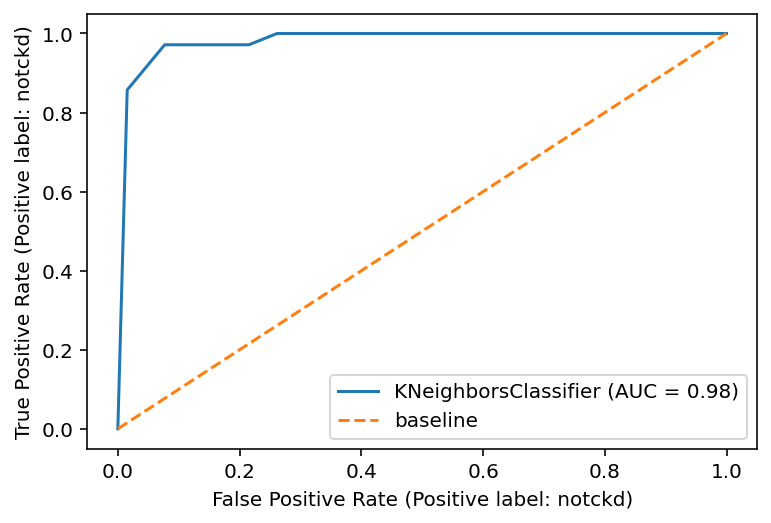

In [ ]:
plot_roc_curve(knn,X_test_sc,y_test)
plt.plot ([0,1],[0,1],
          label = 'baseline', linestyle='--' )
plt.legend();

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer:

In [ ]:
#Unbalanced classes are generally a problem because the minority class is at risk of not having enough exposure during the model process to be accounted for in the model. In other words, since there is so little of the minority class(es), they model cannot sufficiently pick up its signal, resulting in its attributes being overlooked/missed during the prediction process.

#I do not believe this is a problem in this particular CKD analysis because the minority class, those without CKD, account for 37.5% of the data set, not a small enough percentage to be concerned about unbalanced-class-issues.

#I would respond by offering to build two versions of the model, one that does not make any changes to offset the unbalanced classes, and one that sets both classes equal by either: 1. oversampling the minority, or negative CKD cases; or 2. undersampling the majority, or positive CKD cases. This would allow us to observe if there are any measurable differences in the models' results.

In [ ]:

df['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

In [ ]:
df_v1['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

In [ ]:
df['class'].value_counts()


ckd       250
notckd    150
Name: class, dtype: int64

In [ ]:
df_v1['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

Answer:

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [ ]:
df_v1.shape

(400, 19)

In [ ]:
df_v1['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

In [ ]:
df_v1_maj = df_v1[ df_v1['class'] == 'ckd' ]
df_v1_min = df_v1[ df_v1['class'] == 'notckd' ]

In [ ]:
df_upsample = resample(df_v1_maj, replace = True, n_samples = 4850, random_state = 42)
df_upsample = pd.concat([df_upsample, df_v1_min])

In [ ]:
df_upsample['class'].value_counts()

ckd       4850
notckd     150
Name: class, dtype: int64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [ ]:
X = df_upsample[v1_features]
y = df_upsample['class']

In [ ]:
X_poly = poly.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state = 42)

In [ ]:
ss.fit(X_train)

StandardScaler()

In [ ]:
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
logreg.fit(X_train_sc, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Earlier score was 0.96666666666

In [ ]:
logreg.score(X_train_sc, y_train)

0.9968

In [ ]:
# Earlier score was 0.96

In [ ]:
logreg.score(X_test_sc, y_test)


0.9976

In [ ]:
predictions = logreg.predict(X_test_sc)

In [ ]:
cm = confusion_matrix(y_test, predictions)

In [ ]:
cm

array([[1208,    0],
       [   3,   39]])

In [ ]:

cm = pd.DataFrame(cm, columns=['Predicted Negative','Predicted Positive'], index=['Actual Negative','Actual Positive'])

In [ ]:
cm

,Predicted Negative,Predicted Positive
Actual Negative,1208,0
Actual Positive,3,39


In [1]:
1208+3+0+39

1250

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

In [ ]:
#The impact of unbalanced classes on logistic regression is that it seems to have concted the specificity of the model, in this case, as there are 0 False Positives out of a total of 1,250 predictions.